# Статистика по продуктам

In [7]:
import matplotlib.pyplot as plt
import psycopg2 as psy
import pandas as pd

from datetime import datetime as dt

def state_flag(row):
    if row['shipped_date'] == None:
        return 1
    else:
        return 0

def sql_to_pd(query, insert_state_flag=False):
    '''
    Функция стучится в базу данных и обрабатывает указанный в аргументе запрос.
    Затем преобразует полученные данные в датафрейм и возвращает его.

    query - SQL запрос в базу данных, которые указанны в функции.
    
    insert_state_flag - подходит исключительно для БД из задания.
                        Если активен, добавляет столбец со статусом
                        заказа в датафрейм используя функцию state_flag()
                        (0-неактивный, 1-активный)
    '''
    try:
        # Connect to an existing database
        connection = psy.connect(user="postgres",
                                  password="Pga1708844!",
                                  host="127.0.0.1",
                                  port="5432",
                                  database="postgres")
        # Create a cursor to perform database operations
        cursor = connection.cursor()
        cursor.execute(query)
        colnames = [desc[0] for desc in cursor.description]
        record = cursor.fetchall()
        # Create a dataframe with the data from a database
        data_frame = pd.DataFrame(record, columns=colnames)
        # Использую функцию выше в случае если нужно поставить флаг статуса заказа, включен по умолчанию
        if insert_state_flag:
            data_frame['order_state'] = data_frame.apply(state_flag, axis=1)
        return data_frame
    except Exception as e:
        print("Error while connecting to PostgreSQL", e)
    finally:
        if (connection):
            cursor.close()
            connection.close()

## 1. Выведите клиента с наибольшим количеством активных заказовМетод to_excel)

In [8]:
df = sql_to_pd('SELECT * FROM orders\
                    INNER JOIN order_details USING(order_id)\
                    INNER JOIN customers USING(customer_id)'
               , insert_state_flag=True
              )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       2155 non-null   object 
 1   order_id          2155 non-null   int64  
 2   employee_id       2155 non-null   int64  
 3   order_date        2155 non-null   object 
 4   required_date     2155 non-null   object 
 5   shipped_date      2082 non-null   object 
 6   ship_via          2155 non-null   int64  
 7   freight           2155 non-null   float64
 8   ship_name         2155 non-null   object 
 9   ship_address      2155 non-null   object 
 10  ship_city         2155 non-null   object 
 11  ship_region       856 non-null    object 
 12  ship_postal_code  2100 non-null   object 
 13  ship_country      2155 non-null   object 
 14  product_id        2155 non-null   int64  
 15  unit_price        2155 non-null   float64
 16  quantity          2155 non-null   int64  


In [9]:
highest_active = df\
                .groupby('customer_id')\
                .agg({'company_name': 'first', 'contact_name': 'first', 'address': 'first', 'order_state':'sum'})\
                .sort_values(by='order_state', ascending=False)\
                .reset_index()
highest_active.rename(columns={'order_state': 'active_orders_count'}, inplace=True)
highest_active.head(1)

,customer_id,company_name,contact_name,address,active_orders_count
0,RATTC,Rattlesnake Canyon Grocery,Paula Wilson,2817 Milton Dr.,25


## 2. Выведите клиентов по количеству активных и неактивных заказов

In [10]:
# неактивные заказы
non_active_orders = df[df['order_state'] == 0][['customer_id','company_name', 'contact_name', 'address', 'order_state']]
non_active_orders = non_active_orders\
                    .groupby('customer_id')\
                    .agg({'company_name': 'first', 'contact_name': 'first', 'address': 'first', 'order_state':'count'})\
                    .reset_index()
non_active_orders.rename(columns={'order_state': 'non_active_count'}, inplace=True)

# активные заказы
active_orders = df[df['order_state'] > 0][['customer_id','company_name', 'contact_name', 'address', 'order_state']]
active_orders = active_orders\
                    .groupby('customer_id')\
                    .agg({'company_name': 'first', 'contact_name': 'first', 'address': 'first', 'order_state':'count'})\
                    .reset_index()
active_orders.rename(columns={'order_state': 'active_count'}, inplace=True)

non_active_orders.merge(active_orders, how='left').fillna(0)

# список всех клиентов и количесво актиных и неактивных заказов

,customer_id,company_name,contact_name,address,non_active_count,active_count
0,ALFKI,Alfreds Futterkiste,Maria Anders,Obere Str. 57,12,0.0
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Avda. de la Constitución 2222,10,0.0
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Mataderos 2312,17,0.0
3,AROUT,Around the Horn,Thomas Hardy,120 Hanover Sq.,30,0.0
4,BERGS,Berglunds snabbköp,Christina Berglund,Berguvsvägen 8,52,0.0
...,...,...,...,...,...,...
84,WARTH,Wartian Herkku,Pirkko Koskitalo,Torikatu 38,37,0.0
85,WELLI,Wellington Importadora,Paula Parente,"Rua do Mercado, 12",19,0.0
86,WHITC,White Clover Markets,Karl Jablonski,305 - 14th Ave. S. Suite 3B,40,0.0
87,WILMK,Wilman Kala,Matti Karttunen,Keskuskatu 45,17,0.0


In [11]:
# однако будет более информативным ваиратнт где мы выберем только тех клиентов которые имеют как активные так и неактивные заказы
clients = non_active_orders.merge(active_orders, how='left').fillna(0)
clients = clients[(clients['active_count'] != 0) & (clients['non_active_count'] != 0)]
clients['active_count'] = clients['active_count'].astype(int)
clients['total_orders'] = clients['active_count'] + clients['non_active_count'] # получаем также сумму активныйх и неактивных заказов
clients = clients.sort_values(by='total_orders', ascending=False)\
                 .reset_index() # сортирую таблицу по общему количеству заказов
clients

,index,customer_id,company_name,contact_name,address,non_active_count,active_count,total_orders
0,19,ERNSH,Ernst Handel,Roland Mendel,Kirchgasse 6,95,7,102
1,62,RATTC,Rattlesnake Canyon Grocery,Paula Wilson,2817 Milton Dr.,46,25,71
2,8,BONAP,Bon app',Laurence Lebihan,"12, rue des Bouchers",41,3,44
3,59,QUEEN,Queen Cozinha,Lúcia Carvalho,"Alameda dos Canàrios, 891",37,3,40
4,42,LEHMS,Lehmanns Marktstand,Renate Messner,Magazinweg 7,35,4,39
5,45,LINOD,LINO-Delicateses,Felipe Izquierdo,Ave. 5 de Mayo Porlamar,31,4,35
6,9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,23 Tsawassen Blvd.,33,2,35
7,44,LILAS,LILA-Supermercado,Carlos González,Carrera 52 con Ave. Bolívar #65-98 Llano Largo,30,4,34
8,39,LAMAI,La maison d'Asie,Annette Roulet,1 rue Alsace-Lorraine,30,1,31
9,65,RICSU,Richter Supermarkt,Michael Holz,Grenzacherweg 237,27,3,30


## 3. Нарисуйте круговую диаграмму по топ 10 самых больших по заказам клиентов, разделенных на активные и неактивные заказы

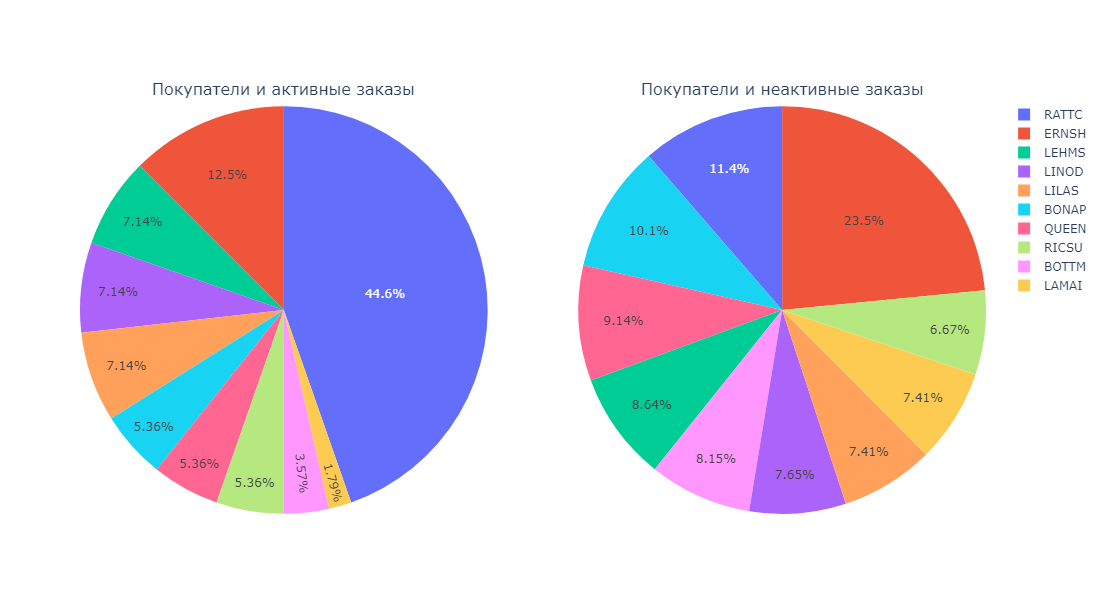

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

clients_top10 = clients.head(10)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]], subplot_titles = ('Покупатели и активные заказы'\
                                                                                                  , 'Покупатели и неактивные заказы'))

fig.add_trace(go.Pie(
values = clients_top10['active_count'],
labels = clients_top10['customer_id'],
domain = dict(x=[0, 0.5]),
name = 'Покупатели и активные заказы'),
row = 1, col = 1)

fig.add_trace(go.Pie(
values = clients_top10['non_active_count'],
labels = clients_top10['customer_id'],
domain = dict(x=[0.5, 1.0]),
name = 'Покупатели и неактивные заказы'),
row = 1, col = 2)

fig.update_layout(width=1000, height=600) 

iplot(fig)



## 4. Выведите продукт с наибольшим количеством активных заказов

In [16]:
# проверяю наименование таблиц, спасибо Chat-GPT
sql_to_pd("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")

,table_name
0,customer_demographics
1,customer_customer_demo
2,customers
3,employees
4,categories
5,products
6,suppliers
7,orders
8,shippers
9,region


In [21]:
products = sql_to_pd("SELECT * FROM products")
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         77 non-null     int64  
 1   product_name       77 non-null     object 
 2   supplier_id        77 non-null     int64  
 3   category_id        77 non-null     int64  
 4   quantity_per_unit  77 non-null     object 
 5   unit_price         77 non-null     float64
 6   units_in_stock     77 non-null     int64  
 7   units_on_order     77 non-null     int64  
 8   reorder_level      77 non-null     int64  
 9   discontinued       77 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       2155 non-null   object 
 1   order_id          2155 non-null   int64  
 2   employee_id       2155 non-null   int64  
 3   order_date        2155 non-null   object 
 4   required_date     2155 non-null   object 
 5   shipped_date      2082 non-null   object 
 6   ship_via          2155 non-null   int64  
 7   freight           2155 non-null   float64
 8   ship_name         2155 non-null   object 
 9   ship_address      2155 non-null   object 
 10  ship_city         2155 non-null   object 
 11  ship_region       856 non-null    object 
 12  ship_postal_code  2100 non-null   object 
 13  ship_country      2155 non-null   object 
 14  product_id        2155 non-null   int64  
 15  unit_price        2155 non-null   float64
 16  quantity          2155 non-null   int64  


In [23]:
clients_and_products = df.merge(products, on='product_id', how='left')
clients_and_products = clients_and_products[['customer_id', 'order_id', 'product_id', 'product_name', 'order_state']]
clients_and_products

,customer_id,order_id,product_id,product_name,order_state
0,VINET,10248,11,Queso Cabrales,0
1,VINET,10248,42,Singaporean Hokkien Fried Mee,0
2,VINET,10248,72,Mozzarella di Giovanni,0
3,TOMSP,10249,14,Tofu,0
4,TOMSP,10249,51,Manjimup Dried Apples,0
...,...,...,...,...,...
2150,RATTC,11077,64,Wimmers gute Semmelknödel,1
2151,RATTC,11077,66,Louisiana Hot Spiced Okra,1
2152,RATTC,11077,73,Röd Kaviar,1
2153,RATTC,11077,75,Rhönbräu Klosterbier,1


## 5. Выведите количества продуктов разделенные по активности

## 6. Нарисуйте диаграмму по топ 10 самым продаваемым продуктам

## 7. Добавьте в вашу таблицу должность и имя сотрудника, а также его город, гдеон работает

## 8. Теперь выведите количество активных и неактивных заказов по сотрудникам

## 9. Выгрузите таблицу с заказами и сотрудниками в эксель. (Метод to_excel)